In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
import os
from glob import glob

import numpy as np

import tensorflow as tf
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data_paths = glob('dataset/mnist_png/training/*/*.png')
data_paths[0]

'dataset/mnist_png/training/0/1.png'

In [4]:
path = data_paths[0]
path

'dataset/mnist_png/training/0/1.png'

In [5]:
tf.io.matching_files('dataset/mnist_png/training/*/*.png')

<tf.Tensor: shape=(60000,), dtype=string, numpy=
array([b'dataset/mnist_png/training/0/1.png',
       b'dataset/mnist_png/training/0/1000.png',
       b'dataset/mnist_png/training/0/10005.png', ...,
       b'dataset/mnist_png/training/9/9968.png',
       b'dataset/mnist_png/training/9/9969.png',
       b'dataset/mnist_png/training/9/9998.png'], dtype=object)>

## Load image

In [6]:
gfile = tf.io.read_file(path)
image = tf.io.decode_image(gfile)
image.shape

TensorShape([28, 28, 1])

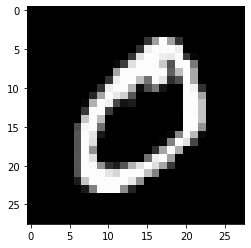

In [7]:
plt.imshow(image[:, :, 0], 'gray')
plt.show()

## set data generator

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True
)

In [10]:
inputs = image[tf.newaxis, ...]
inputs.shape

TensorShape([1, 28, 28, 1])

In [11]:
image = next(iter(datagen.flow(inputs)))

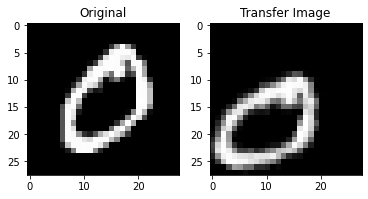

In [12]:
plt.subplot(121)
plt.title('Original')
plt.imshow(np.squeeze(inputs), 'gray')

plt.subplot(122)
plt.title('Transfer Image')
plt.imshow(np.squeeze(image), 'gray')

plt.show()

## transformation
- shift+tab 하면 보임

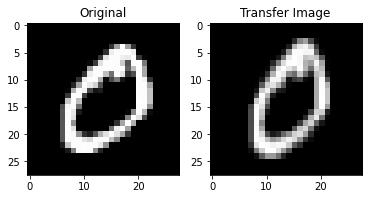

In [13]:
datagen = ImageDataGenerator(
    #width_shift_range=0.3,
    zoom_range=0.3
)

outputs = next(iter(datagen.flow(inputs)))

plt.subplot(121)
plt.title('Original')
plt.imshow(np.squeeze(inputs), 'gray')

plt.subplot(122)
plt.title('Transfer Image')
plt.imshow(np.squeeze(outputs), 'gray')

plt.show()

## rescale시 주의사항

In [14]:
train_datagen = ImageDataGenerator(
    zoom_range=0.7,
    rescale=1./255
)

test_datagen = ImageDataGenerator(rescale=1./255)

## Hyperparameter tunning

In [15]:
os.listdir('dataset/mnist_png/training')

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [16]:
train_dir = 'dataset/mnist_png/training'
test_dir = 'dataset/mnist_png/testing'

In [17]:
num_epochs = 10
batch_size = 32

learning_rate = 0.001

dropout_rate = 0.7

input_shape = (28, 28, 1)
num_classes = 10

## preprocess

In [18]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.3,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [19]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = input_shape[:2],
    batch_size = batch_size,
    color_mode = 'grayscale',
    class_mode = 'categorical'
)

Found 60000 images belonging to 10 classes.


In [20]:
val_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = input_shape[:2],
    batch_size = batch_size,
    color_mode = 'grayscale',
    class_mode = 'categorical'
)

Found 10000 images belonging to 10 classes.


## building model

In [21]:
from tensorflow.keras import layers

In [22]:
inputs = layers.Input(input_shape)
net = layers.Conv2D(32, (3, 3), padding='SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Flatten()(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(dropout_rate)(net)
net = layers.Dense(num_classes)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name='Basic_CNN')

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## training

In [24]:
model.fit_generator(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=num_epochs,
                    validation_data=val_generator,
                    validation_steps=len(val_generator))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
1875/1875 [==============================] - 125s 67ms/step - loss: 0.8484 - accuracy: 0.7094 - val_loss: 0.4330 - val_accuracy: 0.8719
Epoch 2/10
1875/1875 [==============================] - 118s 63ms/step - loss: 0.4860 - accuracy: 0.8385 - val_loss: 0.2530 - val_accuracy: 0.9323
Epoch 3/10
1875/1875 [==============================] - 119s 63ms/step - loss: 0.3879 - accuracy: 0.8777 - val_loss: 0.1513 - val_accuracy: 0.9581
Epoch 4/10
1875/1875 [==============================] - 106s 57ms/step - loss: 0.3225 - accuracy: 0.8988 - val_loss: 0.1160 - val_accuracy: 0.9674
Epoch 5/10
1875/1875 [==============================] - 112s 60ms/step - loss: 0.2979 - accuracy: 0.9070 - val_loss: 0.0925 - val_accuracy: 0.9745
Epoch 6/10
1875/1875 [==============================] - 115s 61ms/step - loss: 0.2793 - accuracy: 0.9147 - val_loss: 0.1048 - val_accuracy: 0.9669
Epoch 7/10
1875/1875 [====================